In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg as LA
from scipy.stats import norm 

## Table des matières.
1. [Méthodes numériques pour la recherche d'un zéro en dimension 1](#part1) \
    1.1 [Méthode de Dichotomie](#part11)  \
    1.2 [Méthode de Newton](#part12) \
    1.3 [Méthode de la sécante](#part13) 
2. [Méthodes numériques pour la recherche d'un zéro en dimension N](#part2) \
    2.1 [Méthode de Newton en dimension N](#part21)\
    2.2 [Méthode de Newton approchée en dimension N](#part22) 
3. [Calcul des rendements d'une obligation](#part3)
4. [Volatilité implicite](#part4) \
    4.1 [Cas du call](#part41) \
    4.2 [Cas du put](#part42) 
5. [Détermination des taux zéro coupon : bootstrapping](#part5)

### 1) Méthodes numériques pour la recherche d'un zéro en dimension 1.<a id="part1"></a>

> **Problème :**
Durant toute cette section, notre objectif sera de trouver les zéros de $f(x) = x^4-5x^2+4-\dfrac{1}{1+\text{e}^{x^3}}.$

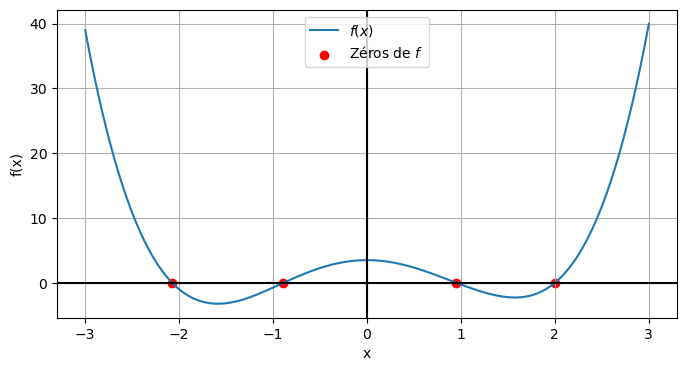

In [2]:
def f(x) : 
    return x**4 - 5*x**2 + 4 - 1/(1+np.exp(x**3))

x = np.linspace(-3, 3, 400)
y = f(x)
zeros = [-2.0743, -0.889642, 0.950748, 2.00003]
plt.figure(figsize=(8, 4))
plt.plot(x, y, label=fr"$f(x)$")
plt.scatter(zeros, [0,0,0,0], color='r', label=fr"Zéros de $f$", alpha = 1)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend(loc='upper center')
plt.grid(True)
plt.axhline(0, color='black',linewidth=1.5)
plt.axvline(0, color='black',linewidth=1.5)
plt.show()

#### 1.1) Méthode de Dichotomie.<a id="part11"></a>

Commençons par introduire la méthode la plus simple qu'il soit pour rechercher une telle solution. Faisons l'hypothèse que $f : [a,b] \rightarrow \mathbb{R}$ est une fonction continue et que $f(a) \times f(b) < 0$, autrement dit que le signe de $f(a)$ est différent du signe de $f(b)$. Par le théorème des valeurs intermédiaires il vient que : 
$$ \exists x \, \in \, [a,b] \, \text{t.q.} \, f(x) = 0.$$

Au sein de l'intervalle $[a,b]$, il peut y avoir plusieurs solution au problème $f(x) = 0$, cependant cette méthode ne permet que d'en trouver un seul. 

Le principe général est le suivant : 
* nous allons subdiviser l'intervalle $[a,b]$ en deux sous-intervalles $[a,c], [c,b]$ où $c = \dfrac{a+b}{2}$.
* deux cas se présentent : soit $f(a) \times f(c) < 0$, soit $f(c) \times f(b) < 0$. Si $f(a)$ et $f(c)$ sont de signe différents, alors on ré-itère avec $[a,c]$, sinon on ré-itère avec $[c,b]$. 

Afin de limiter la recherche, il faut introduire des seuils de tolérance. Premièrement, nous allons introduire `seuil_approx`, dès que celui-ci sera franchit nous considérerons que nous avons trouvé une solution. 
Deuxièmement, nous utiliserons `seuil_int`, la plus grande valeur de l'intervalle contenant la solution.

In [3]:
def bisection_method(a,b,f,seuil_int, seuil_approx) : 
    # Vérification de l'hypothèse du signe des images par f des bornes de l'intervalle : 
    if(f(a) * f(b) > 0) : 
        print("Erreur : les images sont de même signe.")
        return 0 
    
    # Au cas où les bornes sont solutions. 
    if(np.abs(f(a)) < seuil_approx) : return a
    if(np.abs(f(b)) < seuil_approx) : return b 
    
    left = a 
    right = b
    while max(np.abs(f(left)), np.abs(f(right))) > seuil_approx or right - left > seuil_int:
        mid = (left + right) / 2
        if(f(left) * f(mid) < 0) : 
            right = mid 
        else : 
            left = mid 
    return mid 

In [4]:
seuil_approx = 1e-9
seuil_int = 1e-6 
a = -2
b = 3 
bisection_method(a,b,f,seuil_int, seuil_approx)

-0.8896418140211608

#### 1.2) Méthode de Newton. <a id="part12"></a>
Afin de pouvoir utiliser cette méthode, il est primordial d'avoir une expression explicite de la dérivée de $f$, puisque nous serons amené à considérer le développement de Taylor au premier ordre. 

En effet, partons d'un point $x_0$ que l'on choisit de préférence proche du zéro à trouver (à l'aide d'estimations préalables), on approche la fonction au premier ordre. Ce qui donne : 

$$ f(x) \approx f(x_0) + f'(x_0)(x-x_0)$$



On calcule ensuite l'intersection de la droite tangente avec l'axe des abscisses, ce qui revient à résoudre :

$$ f(x_0) + f'(x_0)(x-x_0) = 0 $$

$$ \Leftrightarrow x = x_0 - \dfrac{f(x_0)}{f'(x_0)} $$ 

On obtient alors un point $x_1$ qui est (en général) une meilleure approximation que $x_0$ de la solution recherchée. 

Ainsi, nous allons construire par récurrence la suite $(x_k)_{k \geq 0}$ définie par : 

$$ x_{k+1} = x_k - \dfrac{f(x_k)}{f'(x_k)}, x_0 = x_0 \, (\star)$$ 

> **Remarque:** Le choix d'un $x_0$ cohérent est primordial. Nous verrons plus tard que par exemple dans le cas d'un calcul de volatilité implicite, un bon choix est par exemple $x_0 = 0.20$ (correpondant à une volatilité de $20 \%$), alors que $x_0 = 15$ ou $x_0 = -5$ se révèlent être des mauvais choix (et la méthode pourrait même ne pas converger en entrant dans une boucle infinie).

In [5]:
def f_prime(x) : 
    return 4*x**3 + 3*x**2*np.exp(x**3)/(np.exp(x**3) + 1)**2 - 10*x

Voici l'implémentation de la méthode de Newton. Elle renvoie un tuple `(float, int)`, où le second élement est le nombre d'itérations de la méthode pour obtenir un valeur satisfaisante (sous le seuil imposé). 

In [6]:
def newton_method(x_0, f, f_prime, seuil_int, seuil_approx) : 
    x_new = x_0
    x_old = x_0 - 1 
    nb_iterations = 0 
    while np.abs(f(x_new)) > seuil_approx or np.abs(x_new - x_old) > seuil_int:
        x_old = x_new
        x_new = x_old - f(x_old)/f_prime(x_old)
        nb_iterations += 1
    return x_new, nb_iterations

In [7]:
print(newton_method(-3, f, f_prime, seuil_int, seuil_approx))
print(newton_method(-0.5, f, f_prime, seuil_int, seuil_approx))
print(newton_method(0.5, f, f_prime, seuil_int, seuil_approx))
print(newton_method(3, f, f_prime, seuil_int, seuil_approx))

(-2.0743044028661344, 6)
(-0.889641813973701, 4)
(0.9507482560163691, 4)
(2.000027935245084, 7)


>**Remarque:** Nous aurions pu calculer la dérivée de $f$ avec la bibliothèque `sympy`, permettant à la fois de l'expliciter et de l'évaluer aux points souhaités. 

#### 1.3) Méthode de la sécante.<a id="part13"></a>
Dans un nombre accru de problèmes mathématiques, la dérivée n'est pas accessible directement ou peut être compliquée à expliciter. Cette méthode (moins bonne que celle de Newton), permet de faire une approximation de la dérivée au moyen de différences finies : 
$$ f'(a) \approx \dfrac{f(a+h)-f(a)}{h}, $$ pour $h$ suffisamment proche de $0$.  
En posant $a = x_k, h = x_k - x_{k-1}$, on obtient : 
$$ f'(x_k) \approx \dfrac{f(x_k)-f(x_{k-1})}{x_k - x_{k-1}}, $$ que l'on injecte directement dans la suite récurrente $(\star)$.
Finalement : 

$$ x_{k+1} = x_k - \dfrac{(x_k-x_{k-1})f(x_k)}{f(x_k)-f(x_{k-1})} \, \forall \,k \geq 0.$$ 

Contraiment à la méthode de Newton, deux approximations $x_{-1}$ et $x_0$ doivent préalablement être réalisées. Ces dernières sont choisies raisonnablement en fonction du contexte. Ici également, pour des valeurs non cohérentes, la méthode peut diverger. 

In [8]:
def secant_method(x_minus1, x_0, f, seuil_int, seuil_approx) : 
    x_new = x_0
    x_old = x_minus1
    nb_iterations = 0
    while np.abs(f(x_new)) > seuil_approx or np.abs(x_new - x_old) > seuil_int : 
        x_oldest = x_old
        x_old = x_new
        x_new = x_old - f(x_old)*(x_old-x_oldest)/(f(x_old)-f(x_oldest))
        nb_iterations += 1
    return x_new, nb_iterations

In [9]:
print(secant_method(-2.5,-2.25, f, seuil_int, seuil_approx))
print(secant_method(-1,-0.75, f, seuil_int, seuil_approx))
print(secant_method(0.75,1, f, seuil_int, seuil_approx))
print(secant_method(2.25,2.5, f, seuil_int, seuil_approx))

(-2.0743044028666073, 6)
(-0.8896418139736726, 4)
(0.95074825601641, 4)
(2.0000279352451216, 7)


### 2) Méthodes numériques pour la recherche d'un zéro en dimension N.<a id="part2"></a>

>**Problème:** Durant toute cette section, notre objectif sera de trouver les zéros de la fonction $$ F : x \, \in \mathbb{R}^3 \rightarrow \begin{pmatrix}
x_1^3+2x_1x_2+x_3^2-x_2x_3 +9 \\
2x_1^2 + 2x_1x_2^2+x_2^3x_3^2-x_2^2x_3 -2 \\ 
x_1x_2x_3 + x_1^3 - x_3^2 - x_1x_2^2-4
\end{pmatrix},$$ où : 
>$$\nabla F = \left(\begin{matrix} 
3x_1^2 + 2x_2 & 2x_1 - x_3 & 2x_3 - x_2 \\ 
4x_1 + 2x_2^2 & 4x_1x_2 + 3x_2^2x_3^2 - 2x_2x_3 & 2x_2^2x_3 - x_2^2 \\ 
x_2x_3 + 3x_1^2 - x_2^2 & x_1x_3 - 2x_1x_2 & x_1x_2 - 2x_3 \\ 
\end{matrix}\right).
$$

In [10]:
def F(x):
    return np.array([
        x[0]**3 + 2*x[0]*x[1] + x[2]**2 - x[1]*x[2] + 9, 
        2*x[0]**2 + 2*x[0]*x[1]**2 + x[1]**3*x[2]**2 - x[1]**2*x[2] - 2, 
        x[0]*x[1]*x[2] + x[0]**3 - x[2]**2 - x[0]*x[1]**2 - 4 ])

In [11]:
def gradient_F(x):
    return np.array([[3*x[0]**2 + 2*x[1], 2*x[0] - x[2], 2*x[2] - x[1]],
                     [4*x[0] + 2*x[1]**2, 4*x[0]*x[1] + 3*x[1]**2*x[2]**2 - 2*x[1]*x[2], 2*x[1]**2*x[2] - x[1]**2],
                     [x[1]*x[2] + 3*x[0]**2 - x[1]**2, x[0]*x[2] - 2*x[0]*x[1], x[0]*x[1] - 2*x[2]]])

result = gradient_F(np.array([-1, 3, 1]))
print(result)

[[ 9 -3 -1]
 [14  9  9]
 [-3  5 -5]]


#### 2.1) Méthode de Newton en dimension N.<a id="part21"></a>
De manière générale, soit $F : \mathbb{R}^N \rightarrow \mathbb{R}^N$, qui est supossée de classe $\mathcal{C}^1(\mathbb{R}^N)$. 
Comme en section 1.2, nous avons recours au développement de Taylor : 

$$ F(x_{k+1}) \approx F(x_k) + \nabla F(x_k)(x_{k+1}-x_k).$$

En approchant $F(x_{k+1})$ par $0$ (cette hypothèse est raisonnable en raison du choix des conditions initiales) : 

$$ 0 \approx F(x_k) + \nabla F(x_k)^t(x_{k+1}-x_k)$$

$$ \Leftrightarrow x_{k+1} = x_k - \nabla F(x_k))^{-1}F(x_k)$$ 


En pratique, on ne calcule pas $\nabla F(x_k))^{-1}$, car c'est très coûteux. Remarquons que c'est équivalent au fait de résoudre le système linéaire : 

$$ \nabla F(x_k)v_k = F(x_k), \text{  où   }v_k = (\nabla F(x_k))^{-1}F(x_k),$$

qui peut facilement s'obtenir au moyen de `numpy.linalg.solve`. 

Au final la formule de récurrence de la suite $(x_k)_{k \geq 0}$ est : 

$$ x_{k+1} = x_k -v_k. $$ 

De plus pour calculer la norme euclidienne (celle que nous utiliserons pour juger de la validité du résultat), on aura besoin de `numpy.linalg.norm` dont l'argument par défaut permet de calculer la norme souhaitée (norme euclidienne). 

In [12]:
def newton_N_method(x0, F, gradient_F, seuil_int, seuil_approx) : 
    x_new = x0
    x_old = x0 - np.ones(x0.shape) # Ou len(x0) pour une liste.
    nb_iterations = 0 
    while LA.norm(F(x_new)) > seuil_approx or LA.norm(x_new-x_old) > seuil_int : 
        x_old = x_new 
        grad = gradient_F(x_old)
        x_new = x_old - LA.solve(grad, F(x_old))
        nb_iterations += 1
    return x_new, nb_iterations

In [13]:
print(newton_N_method(np.array([1,2,3]), F, gradient_F, seuil_int, seuil_approx))

(array([-1.69055076,  1.98310724, -0.88455808]), 55)


#### 2.2) Méthode de Newton approchée en dimension N. <a id="part22"></a>

Toujours dans le contexte dans la méthode la sécante, on approche le gradient de $F$ par différences finies (vraie valeur trop couteuse à calculer, ou tout simplement impossible). En notant $(e_i)_{1 \leq i \leq N}$ la base canonique de $\mathbb{R}^N$, il vient que (pour $h \rightarrow 0$): 

$$ \dfrac{\partial F_i}{\partial x_j}(x) \approx \Delta_jF_i(x) = \dfrac{F_i(x+he_j)-F_i(x)}{h}$$ 

Posons alors : 

$$ \Delta F(x) = \left(\begin{matrix}
\Delta_1F_1(x) & \Delta_2F_1(x) & \cdots & \Delta_NF_1(x)\\
\Delta_1F_2(x) & \Delta_2F_2(x) & \cdots & \Delta_NF_2(x)\\
\vdots & \vdots & \ddots & \vdots\\
\Delta_1F_N(x) & \Delta_2F_N(x) & \cdots & \Delta_NF_N(x)\\
\end{matrix}\right).
$$

Il suffit alors de remplacer $\nabla F$ par $\Delta F$ dans la formule de Newton : 

$$x_{k+1} = x_k - \left(\Delta F(x_k)\right)^{-1}F(x_k),$$

comme précédemment remarquons que c'est équivalent au fait de résoudre le système linéaire : 

$$ \Delta F(x_k)v_k = F(x_k), \text{  où   }v_k = (\Delta F(x_k))^{-1}F(x_k),$$

Finalement la formule de récurrence est : 

$$ x_{k+1} = x_k -v_k.$$

Implémentons une routine `compute_approx_grad(F, N, x, h)` implémentant la matrice $\Delta F(x)$ selon la précédente définition.
* `F`, la fonction considérée. 
* `N`, dimension de l'espace sur lequel $F$ est définie. 
* `x`, vecteur passé en argument. 

In [14]:
def compute_approx_grad(F, N, x, h) : 
    res = []
    for i in range(1,N+1) :
        line = []
        for j in range(1, N+1) : 
            e = np.zeros(N) 
            e[j-1] = 1 
            line.append((F(x+e*h)[i-1]-F(x)[i-1])/h)
        res.append(line)      
    return res

print("Approx. avec diff. finies : \n", compute_approx_grad(F,3, [1,1,1],0.001))
print("\n")
print("`Vrai` gradient : \n", gradient_F([1,1,1]))


Approx. avec diff. finies : 
 [[5.003000999998619, 0.9999999999994458, 1.0010000000004737], [6.001999999998731, 5.004000999999647, 1.0010000000004737], [3.0030009999997276, -1.0009999999995856, -1.0009999999995856]]


`Vrai` gradient : 
 [[ 5  1  1]
 [ 6  5  1]
 [ 3 -1 -1]]


Terminons par le code de la fonction `newton_N_method_approx`, sur le modèle de `newton_N_method`. 

In [15]:
def newton_N_method_approx(x0, F, seuil_int, seuil_approx) : 
    x_new = x0
    x_old = x0 - np.ones(len(x0))
    h = seuil_int 
    N = len(x0)
    nb_iterations = 0 
    while LA.norm(F(x_new)) > seuil_approx or LA.norm(x_new-x_old) > seuil_int : 
        x_old = x_new 
        grad_approx = compute_approx_grad(F, N, x_old, h)
        x_new = x_old - LA.solve(grad_approx, F(x_old))
        nb_iterations += 1
    return x_new, nb_iterations

x_new, nb_iterations = newton_N_method_approx(np.array([2,2,2]), F, seuil_int, seuil_approx)
print(x_new, " trouvé avec ", nb_iterations, " itérations.")
x_new, nb_iterations = newton_N_method_approx(np.array([1,2,3]), F, seuil_int, seuil_approx)
print(x_new, " trouvé avec ", nb_iterations, " itérations.")

[-1.  3.  1.]  trouvé avec  79  itérations.
[-1.69055076  1.98310724 -0.88455808]  trouvé avec  9  itérations.


### 3) Calcul des rendements d'une obligation.<a id="part3"></a>

Nous avons vu dans le document *Chapter 1 : Integral Approximation and Bond Pricing* une analyse détaillée des obligations, traitant en particulier de $y$, le rendement de l'obligation aussi appelé le taux actuariel. Pour rappel, c'est le taux constant auquel la somme des flux futurs actualisés de l'obligation est égal au prix de l'obligation. En d'autres termes : 


$$ B = \displaystyle \sum_{i=1}^n c_i\,\text{exp}(-yt_i).$$

Pour un prix $B$ donné, cette équation est une équation non linéaire en $y$ : nous allons utiliser la méthode de Newton pour approcher $y$. 

On pose alors : 

$$f(x) = \displaystyle \sum_{i=1}^{n} c_i\mathrm{e}^{-xt_i} - B.$$

Cette fonction est clairement dérivable sur $\mathbb{R}$ (elle y est même $\mathcal{C}^{\infty}$), on obtient par linéarité de l'opérateur dérivation : 

$$f'(x) = -\displaystyle \sum_{i=1}^{n} t_ic_i\mathrm{e}^{-xt_i}.$$

En appliquant à présent la méthode de Newton (c.f. section $1.2$) avec : 

$$x_{k+1} = x_k - \dfrac{f(x_k)}{f'(x_k)} = x_k + \dfrac{\displaystyle \sum_{i=1}^{n} c_i\mathrm{e}^{-xt_i} - B}{\displaystyle \sum_{i=1}^{n} t_ic_i\mathrm{e}^{-xt_i}},$$ 
et $x_0 = 0.1$ (c'est à dire $10\%$, qui est une estimation raisonnable pour le rendement d'une obligation).

In [16]:
def f(x, B, n, t_cash_flow, v_cash_flow) : 
    t_cash_flow = np.array(t_cash_flow)
    c_cash_flow = np.array(v_cash_flow)
    return np.sum(v_cash_flow * np.exp(-x * t_cash_flow)) - B

In [17]:
def f_prime(x, B, n, t_cash_flow, v_cash_flow) : 
    t_cash_flow = np.array(t_cash_flow)
    c_cash_flow = np.array(v_cash_flow)
    return -np.sum(v_cash_flow * t_cash_flow * np.exp(-x * t_cash_flow))

In [18]:
def bond_yield(x0, B, n, t_cash_flow, v_cash_flow) : 
    x_new = x0
    x_old = x0 - 1 
    seuil = 1e-6
    while np.abs(x_new - x_old) > seuil : 
        x_old = x_new 
        x_new = x_old - f(x_old, B, n, t_cash_flow, v_cash_flow)/f_prime(x_old, B, n, t_cash_flow, v_cash_flow)
    return x_new

> **Exemple:** Utiliser la méthode de Newton pour trouver le rendement de l'obligation de maturité $T = 5$ ans, à coupon bi-annuel où $C = 3.375 \%$, et de prix $B = 100+\dfrac{1}{32}$. 

In [19]:
n = 10
B = 100+1/32
C = 0.03375
F = 100
t_cash_flow = [6/12, 12/12, 18/12, 24/12, 30/12, 36/12, 42/12, 48/12, 54/12, 60/12]
c_cash_flow = [C/2*F] * (n-1) + [(1 + C/2)*F]

print("y = ", bond_yield(0.1, B, n, t_cash_flow, c_cash_flow)) # y = 3.3401 % 

y =  0.03340109853803073


Avec le rendement $y$ de l'obligation, il est à présent possible de calculer la duration $D$ et la convexité $C$. Afin de vérifier que notre précédente implémentation est correcte, on peut par ce biais remonter au prix de l'obligation $B$. Pour plus de détails à ce sujet je vous renvoie vers le document *Chapter 1 : Integral Approximation and Bond Pricing*. 

Par définition : 

$$ B = \displaystyle \sum_{i=1}^n c_i\,\text{exp}(-yt_i),\, D = \dfrac{1}{B} \sum_{i=1}^n t_ic_i \, \text{exp}(-yt_i), \,C = \dfrac{1}{B}\displaystyle\sum_{i=1}^n t_i^2c_i\,\text{exp}(-yt_i).$$

Introduisons `price_duration_convexity`, afin de calculer ces quantités renvoyées sous forme de tuple.  

In [21]:
def price_duration_convexity(n,t_cash_flow, c_cash_flow, y) : 
    B = 0
    D = 0
    C = 0
    for i in range (0,n) : 
        discount_factor = np.exp(-t_cash_flow[i]*y)
        B += c_cash_flow[i]*discount_factor
        D += t_cash_flow[i]*c_cash_flow[i]*discount_factor
        C += t_cash_flow[i]**2*c_cash_flow[i]*discount_factor 
    D /= B 
    C /= B
    return B,D,C

In [22]:
n = 10
B = 100+1/32
C = 0.03375
F = 100
t_cash_flow = [6/12, 12/12, 18/12, 24/12, 30/12, 36/12, 42/12, 48/12, 54/12, 60/12]
c_cash_flow = [C/2*F] * (n-1) + [(1 + C/2)*F]
y = bond_yield(0.1, B, n, t_cash_flow, c_cash_flow)

new_B, D, C = price_duration_convexity(n, t_cash_flow, c_cash_flow, y)
print("B = ", B)
print("new_B = ", new_B) # Erreur d'arrondi suite à l'approximation de y par la routine `bond_yield`. 
print("D = ", D)
print("C = ", C)

B =  100.03125
new_B =  100.03125000009308
D =  4.642735048425559
C =  22.57311801585167


### 4) Volatilité implicite.<a id="part4"></a>

Dans la formule de l'évaluation d'options de Black-Scholes, un seul paramètre ne peut être observé directement : la volatilité de l'action. Nous allons donc se servir des équations de Black-Scholes, mais à l'envers. On part du prix de marché de l'option pour en déduire la volatilité que les opérateurs de marché estiment pour l'avenir.

#### 4.1) Cas du call. <a id="part41"></a>
Nous rappelons la formule de Black-Scholes pour un call de sur l'actif sous jacent $S$, de maturité $T$ et de strike $K$. On suppose également que le sous jacent paie des dividendes à rythme continu au taux $q$. Enfin, le taux sans risque est $r$. On a pour tout $ 0 \leq t < T$ : 

$$C_t = S_t\text{e}^{-q(T-t)}\mathcal{N}(d_1) - K\text{e}^{-r(T-t)}\mathcal{N}(d_2),$$

avec $d_1 = \dfrac{\ln{\left(\dfrac{S}{K}\right)} + \left(r-q+\dfrac{\sigma ^2}{2}\right)(T-t)}{\sigma \sqrt{T-t}}$, $d_2 = d_1 - \sigma \sqrt{T-t} = \dfrac{\ln{\left(\dfrac{S}{K}\right)} + \left(r-q-\dfrac{\sigma ^2}{2}\right)(T-t)}{\sigma \sqrt{T-t}}.$

Pour des raisons de clarté, on pose ici $t = 0$. Trouver la volatilité implicite revient à résoudre l'équation $f(x) = 0$ où : 

$$f(x) = S_0\text{e}^{-qT}\mathcal{N}(d_1(x)) - K\text{e}^{-rT}\mathcal{N}(d_2(x)) - C_0,$$

avec donc  $d_1 = \dfrac{\ln{\left(\dfrac{S}{K}\right)} + \left(r-q+\dfrac{x^2}{2}\right)T}{\sigma \sqrt{T}}$, $d_2 = d_1 - x\sqrt{T} = \dfrac{\ln{\left(\dfrac{S}{K}\right)} + \left(r-q-\dfrac{x^2}{2}\right)T}{\sigma \sqrt{T}}.$

Afin de pouvoir appliquer la méthode de Newton, il faut dériver $f$ par rapport à $x$. Ceci revient par définition, à calculer le vega du call. Ce dernier est défini comme 

$$ \text{vega}(C) = \dfrac{\partial C}{\partial \sigma}.$$

Calculons le :  

$$\dfrac{\partial C}{\partial \sigma} = S_0\text{e}^{-qT}\mathcal{N}'(d_1)\dfrac{\partial d_1}{\partial \sigma} - K\text{e}^{-rT}\mathcal{N}'(d_2)\dfrac{\partial d_2}{\partial \sigma}, $$ par la règle de chaîne. 

$$\Leftrightarrow \dfrac{\partial C}{\partial \sigma} = S_0\text{e}^{-qT}\mathcal{N}'(d_1)\left(\dfrac{\partial d_1}{\partial \sigma}-\dfrac{\partial d_2}{\partial \sigma}\right),$$
en utilisant le fait que $ S_0\text{e}^{-qT}\mathcal{N}'(d_1) = K\text{e}^{-rT}\mathcal{N}'(d_2)$. 

Pour plus de détails consulter le document *Chapter 4 : Greeks and Hedging*. 

$$\Leftrightarrow \dfrac{\partial C}{\partial \sigma} = S_0\text{e}^{-qT}\dfrac{\partial \left(d_1-d_2\right)}{\partial \sigma}\dfrac{1}{\sqrt{2\pi}}\text{e}^{-\frac{d_1^2}{2}},$$ et comme $d_1-d_2 = \sigma \sqrt{T}$ :

$$\Leftrightarrow \dfrac{\partial C}{\partial \sigma} = S_0\text{e}^{-qT}\sqrt{T}\dfrac{1}{\sqrt{2\pi}}\text{e}^{-\frac{d_1^2}{2}}.$$

Commençons par implémenter la fonction $f(x)$, ainsi que sa dérivée, $\text{vega}(x)$. 

In [23]:
def f_call(x,C,S,K,T,q,r) : 
    d1 = (np.log(S/K) + (r-q+x*x/2)*(T))/(x*np.sqrt(T))
    d2 = d1-x*np.sqrt(T)
    return S*np.exp(-q*T)*norm.cdf(d1)-K*np.exp(-r*T)*norm.cdf(d2) - C

In [24]:
def vega(x,S,K,T,q,r) : 
    d1 = (np.log(S/K) + (r-q+x*x/2)*(T))/(x*np.sqrt(T))
    return S*np.exp(-q*T)*np.sqrt(T)*1/np.sqrt(2*np.pi)*np.exp(-d1*d1/2)

> **Exemple:**  Trouver la volatilité implicite d'un call $ATM$ de premium $C = 2.5$, 
    de strike $K = 30$, de maturité $T = 1/4$ année de taux de dividendes : $q = 0.02$, avec un taux sans risque de $6 \%$, i.e. $r = 0.06$.
>
> Réaliser ce calcul avec `bisection_method`, `secant_method` et `newton_method`. Comparer. 

In [25]:
T = 1/4 
K = 30 
S = 30 
C = 2.5
q = 0.02 
r = 0.06 
seuil_approx = 1e-9
seuil_int = 1e-6 
a = 0.0001
b = 1

Comme $0 \leq \sigma \leq 1$, on convient de choisir `a = 1e-4` et `b = 1` pour la méthode de Dichotomie. 

In [26]:
a = 0.0001
b = 1

In [27]:
def bisection_method_call_option(a, b, f, C, S, K, T, q, r, seuil_int, seuil_approx) : 
    if(f(a,C,S,K,T,q,r) * f(b,C,S,K,T,q,r)  > 0) : 
        print("Erreur : les images sont de même signe.")
        return 0 
    
    if(np.abs(f(a,C,S,K,T,q,r)) < seuil_approx) : return a
    if(np.abs(f(b,C,S,K,T,q,r)) < seuil_approx) : return b 
    
    left = a 
    right = b
    compteur = 0
    while max(np.abs(f(left,C,S,K,T,q,r)), np.abs(f(right,C,S,K,T,q,r))) > seuil_approx or right - left > seuil_int:
        mid = (left + right) / 2
        if(f(left,C,S,K,T,q,r) * f(mid,C,S,K,T,q,r) < 0) : 
            right = mid 
        else : 
            left = mid 
        compteur+=1
    return mid, compteur  

mid, compteur = bisection_method_call_option(a, b, f_call, C, S, K, T, q, r, seuil_int, seuil_approx)
print("Approx. = ", mid, " avec ", compteur, " itérations.")

Approx. =  0.3970486286657978  avec  33  itérations.


Pour la méthode de la sécante et la méthode de Newton, on choisit $x_0 = 0.5$ et $x_{-1} = 0.6$.  

In [28]:
x_0 = 0.5
x_minus1 = 0.6

In [29]:
def secant_method_call_option(x_minus1, x_0, f, C, S, K, T, q, r, seuil_int, seuil_approx) : 
    x_new = x_0
    x_old = x_minus1
    nb_iterations = 0
    while np.abs(f(x_new,C,S,K,T,q,r)) > seuil_approx or np.abs(x_new - x_old) > seuil_int : 
        x_oldest = x_old
        x_old = x_new
        x_new = x_old - f(x_old,C,S,K,T,q,r)*(x_old-x_oldest)/(f(x_old,C,S,K,T,q,r)-f(x_oldest,C,S,K,T,q,r))
        nb_iterations += 1
    return x_new, nb_iterations

x_new, nb_iterations = secant_method_call_option(x_minus1, x_0, f_call, C, S, K, T, q, r, seuil_int, seuil_approx)
print("Approx. = ", x_new, " avec ", nb_iterations, " itérations.")

Approx. =  0.3970486287323524  avec  3  itérations.


In [30]:
def implied_volatility_call(x0,C,S,K,T,q,r) :  
    x_new = x0
    x_old = x0 - 1
    seuil = 1e-6
    nb_iterations = 0 
    while np.abs(x_new-x_old) > seuil : 
        x_old = x_new 
        x_new -= f_call(x_new, C,S,K,T,q,r)/vega(x_new,S,K,T,q,r)
        nb_iterations +=1 
    return x_new, nb_iterations 

x_new, nb_iterations = implied_volatility_call(x_0,C,S,K,T,q,r)
print("Approx. = ", x_new, " avec ", nb_iterations, " itérations.")

Approx. =  0.39704862873147384  avec  3  itérations.


En conclusion, $\sigma_{imp} \approx 39.71 \%$ obtenu au bout de $3$ itérations (avec une précision de $10^{-6}$). 

#### 4.2) Cas du put. <a id="part42"></a>

Procédons de manière analogue que dans le cas d'un call. Sous les mêmes hypothèses que précédemment, on obtient pour $0 \geq t < T$ : 

$$P_t = K\text{e}^{-r(T-t)}\mathcal{N}(-d_2) - S_t\text{e}^{-q(T-t)}\mathcal{N}(-d_1),$$

avec $d_1 = \dfrac{\ln{\left(\dfrac{S}{K}\right)} + \left(r-q+\dfrac{\sigma ^2}{2}\right)(T-t)}{\sigma \sqrt{T-t}}$, $d_2 = d_1 - \sigma \sqrt{T-t} = \dfrac{\ln{\left(\dfrac{S}{K}\right)} + \left(r-q-\dfrac{\sigma ^2}{2}\right)(T-t)}{\sigma \sqrt{T-t}}.$

Pour des raisons de clarté, on pose ici $t = 0$. Trouver la volatilité implicite revient à résoudre l'équation $f(x) = 0$ où : 

$$f(x) = K\text{e}^{-rT}\mathcal{N}(-d_2) - S_0\text{e}^{-qT}\mathcal{N}(-d_1) - P_0,$$

avec donc  $d_1 = \dfrac{\ln{\left(\dfrac{S}{K}\right)} + \left(r-q+\dfrac{x^2}{2}\right)T}{\sigma \sqrt{T}}$, $d_2 = d_1 - x\sqrt{T} = \dfrac{\ln{\left(\dfrac{S}{K}\right)} + \left(r-q-\dfrac{x^2}{2}\right)T}{\sigma \sqrt{T}}.$

Appliquons une fois de plus la méthode de Newton. Pour cela, il faut dériver $f$, ce qui revient à calculer le vega du put. Autrement dit : 

$$ \text{vega}(P) = \dfrac{\partial P}{\partial \sigma}.$$

On utilise la relation de parité Call-Put : 

$$P_0 = K\text{e}^{-rT} - S_0\text{e}^{-qT}+C_0 $$

Ceci implique directement (comme tous les autres termes ne dépendent pas de $\sigma$), que : 

$$\text{vega}(P) = \text{vega}(C) =S_0\text{e}^{-qT}\sqrt{T}\dfrac{1}{\sqrt{2\pi}}\text{e}^{-\frac{d_1^2}{2}}.$$ 

Implémentons seulement la routine permettant d'évaluer $f(x)$. Comme $\text{vega}(P) = \text{vega}(C)$, la routine `vega` introduite dans la section précédente convient. 

In [31]:
def f_put(x,P,S,K,T,q,r) : 
    d1 = (np.log(S/K) + (r-q+x*x/2)*(T))/(x*np.sqrt(T))
    d2 = d1-x*np.sqrt(T)
    return K*np.exp(-r*T)*norm.cdf(-d2)-S*np.exp(-q*T)*norm.cdf(-d1)-P


f_put(0.75, 3, 25, 25, 1, 0, 0.05)

3.535743156437034

> **Exemple:** En utilisant uniquement la méthode de Newton, calculer la volatilité implicite d'un put $ATM$ de prix $P = 3$, de strike $K = 25$, de maturité $T = 1$ an, ne payant pas de dividendes avec un taux sans risque $r = 0.05$. 

Afin d'illustrer notre propos nous allons trouver la volatilité implicite d'un put de premium $P = 3$, de strike $K = 25$, de maturité $T = 1$ année sur un actif sous-jacent de prix $S_0 = 25$ ne payant pas de dividendes : $q = 0$, avec un taux sans risque de $5 \%$, i.e. $r = 0.05$.

In [32]:
T = 1
K = 25 
S = 25 
P = 3
q = 0
r = 0.05 
seuil_approx = 1e-9
seuil_int = 1e-6 

On choisit comme première estimation $x_0 = 0.5$. 

In [33]:
x_0 = 0.5

In [34]:
def implied_volatility_put(x0,P,S,K,T,q,r) : 
    x_new = x0
    x_old = x0 - 1
    seuil = 1e-6
    nb_iterations = 0 
    while np.abs(x_new-x_old) > seuil : 
        x_old = x_new 
        x_new -= f_put(x_new, P,S,K,T,q,r)/vega(x_new,S,K,T,q,r)
        nb_iterations +=1 
    return x_new, nb_iterations 

In [35]:
x_new, nb_iterations = implied_volatility_put(x_0,P,S,K,T,q,r) 
print("Approx. = ", x_new, " avec ", nb_iterations, " itérations.")

Approx. =  0.36974426673135113  avec  3  itérations.


Autrement dit, $\sigma_{imp} \approx 36.97 \%$, obtenu au bout de 3 itérations, avec une précision de $10^{-6}$.

### 5) Détermination des taux zéro coupon : bootstrapping.<a id="part5"></a>

La méthode du **bootstrapping** est une technique utilisée pour construire une courbe des taux zéro-coupon à partir des prix des obligations couponnées. Pour cela, nous devons rassembler les prix actuels des obligations sur le marché. 

> **Exemple :** Les prix des obligations (à composante semi - annuelle) sont donnés par : 
>
> | Maturité $(T)$ | Coupon annuel (en $\%$)   | Prix de l'oblgiation $(B)$| 
|:----------------:|:-------------------------:|:--------------------:|
| $0.5$            | $0$                       |$99.4665$             |
| $1$              | $0$                       |$98.6196$             |
| $2$              | $2$                       |$101+\dfrac{17.5}{32}$ | 
| $3$              | $4.5$                     |$107+\dfrac{18}{32}$   |
| $5$              | $3.125$                   |$102+\dfrac{8}{32}$    |
| $10$             | $4$                       |$103+\dfrac{8.5}{32}$  | 
>
> Utiliser le bootstrapping pour obtenir une courbe de taux zéro à partir des obligations à $6$ mois, un an, $2$ ans, $5$ ans et $10$ ans. 
>
> Estimer l'erreur relative commise lorsque l'on price le coupon de maturité $T = 3$, avec la courbe des taux zéro coupon obtenue. 


Les taux à 6 mois et 1 an se calculent directement (zéro-coupon) : 

* $99.4565 = 100\text{e}^{-0.5r(0,0.5)} \Leftrightarrow r(0,0.5) = -2\ln \left(\dfrac{99.4565}{100}\right) \approx 0.010899$. Par la suite on utilisera $r(0,0.5) = 0.0109$ soit $1.09 \%$. 

* $98.6196 = 100\text{e}^{-r(0,1)} \Leftrightarrow r(0,1) = -\ln \left(\dfrac{98.6196}{100}\right) \approx 0.0139001$. Par la suite on utilisera $r(0,1) = 0.0139$ soit $1.39 \%$. 

À présent nous allons utiliser le *bootstrapping* pour calculer $r(0,2)$. Par définition : 

$$ 101+\dfrac{17.5}{32} = 100\dfrac{C}{2}\left(\text{e}^{-0.5r(0,0.5)} + \text{e}^{-r(0,1)} + \text{e}^{-1.5r(0,1.5)} \right) + 100\left(1+\dfrac{C}{2}\right)\text{e}^{-2r(0,2)}.$$ 

Par hypothèse $t \rightarrow r(0,t) $ est linéaire sur $[1,2]$. Donc pour tout $ 1 < t < 2$ : 

$$r(0,t) = \dfrac{(2-t)r(0,1)+(t-1)r(0,2)}{2-1} =(2-t)r(0,1)+(t-1)r(0,2).$$

Donc $r(0,1.5) = 0.5\,r(0,1)+0.5\,r(0.2)$.


En posant $x = r(0,2)$, on a finalement l'équation : 

$$ 101+\dfrac{17.5}{32} = 100\dfrac{C}{2}\left(\text{e}^{-0.5r(0,0.5)} + \text{e}^{-r(0,1)} + \text{e}^{-0.75\left(r(0,1)+x\right)} \right) + 100\left(1+\dfrac{C}{2}\right)\text{e}^{-2x}.$$

Appliquons alors la méthode de Newton à : 

$$f(x) = 100\dfrac{C}{2}\left(\text{e}^{-0.5r(0,0.5)} + \text{e}^{-r(0,1)} + \text{e}^{-0.75\left(r(0,1)+x\right)} \right) + 100\left(1+\dfrac{C}{2}\right)\text{e}^{-2x} - 101-\dfrac{17.5}{32}$$

In [36]:
C = 0.02

def f_02(x) : 
    return 100*C/2*(np.exp(-0.5*0.0109)+np.exp(-0.0139)+np.exp(-0.75*(0.0139+x)))+100*(1+C/2)*np.exp(-2*x)-101-17.5/32

def df_02(x) :
    term1 = 100 * C / 2 * (-0.75) * np.exp(-0.75 * (0.0139 + x))
    term2 = 100 * (1 + C / 2) * (-2) * np.exp(-2 * x)
    return term1 + term2

In [37]:
res, nb = newton_method(0.0139, f_02, df_02, seuil_int, seuil_approx)
print("r(0,2) approx. ", res, " obtenu avec ", nb, " iterations.")

r(0,2) approx.  0.012098547617229487  obtenu avec  3  iterations.


On obtient alors $r(0,2) \approx 0.0120985$. Par la suite on utilisera $r(0,2) = 0.012099$, soit $1.2099 \%$. 

Calculons maintenant $r(0,5)$. Par hypothèse $t \rightarrow r(0,t)$ est linéaire sur l'intervalle $[2,5]$. De plus par définition : 

$$ 102+\dfrac{8}{32} = 100\dfrac{C}{2}\left(\text{e}^{-0.5r(0,0.5)} + \text{e}^{-r(0,1)} + \text{e}^{-1.5r(0,1.5)} +\text{e}^{-2r(0,2)}+\text{e}^{-2.5r(0,2.5)}+\text{e}^{-3r(0,3)}+\text{e}^{-3.5r(0,3.5)}+\text{e}^{-4r(0,4)}+\text{e}^{-4.5r(0,4.5)}\right) + 100\left(1+\dfrac{C}{2}\right)\text{e}^{-5r(0,5)}.$$ 

On a pour tout $t \in [2,5]$ : 
$r(0,t) = \dfrac{(5-t)r(0,2)+(t-2)r(0,5)}{3}.$

En posant comme précédemment $x = r(0,5)$ on a : 

* $r(0,2.5) = \dfrac{2.5r(0,2)+0.5x}{3}$
* $r(0,3) = \dfrac{2r(0,2)+x}{3}$
* $r(0,3.5) = \dfrac{1.5r(0,2)+1.5x}{3}$ 
* $r(0,4) = \dfrac{r(0,2)+2x}{3}$ 
* $r(0,4.5) = \dfrac{0.5r(0,2)+2.5x}{3}$ 

Appliquons alors la méthode de Newton à : 

$$f(x) = 100\times\dfrac{C}{2}\left(\text{e}^{-0.5r(0.5)}+\text{e}^{-r(0,1)}+\text{e}^{-0.75(r(0,1)+x))}+\text{e}^{-2r(0,2)} +\text{e}^{-\frac{2.5}{3}(2.5r(0,2)+0.5x)} +\text{e}^{-2r(0,2)-x}+\text{e}^{-\frac{3.5}{3}(1.5r(0,2)+1.5x)}+\text{e}^{-\frac{4}{3}(r(0,2)+2x)}+\text{e}^{-\frac{4.5}{3}(0.5r(0,2)+2.5x)}\right)+100\times\left(1+\dfrac{C}{2}\right)\text{e}^{-5x}-102-\dfrac{8}{32}$$

In [38]:
C = 0.03125
seuil_int = seuil_approx = 1e-12

def f_05(x) : 
    return 100*C/2*(np.exp(-0.5*0.0109) + np.exp(-0.0139) + 
                    np.exp(-0.75*(0.0139+x))+ np.exp(-2*0.012099) + np.exp(-2.5/3*(2.5*0.012099+0.5*x)) +  np.exp(-2*0.012099-x)
                    + np.exp(-3.5/3*(1.5*0.012099+1.5*x)) + np.exp(-4/3*(0.012099+2*x))
                    + np.exp(-4.5/3*(0.5*0.012099+2.5*x)))+100*(1+C/2)*np.exp(-5*x)-102-8/32

def df_05(x):
    const1 = 100 * C / 2
    const2 = 100 * (1 + C / 2)
    
    term1 = const1 * (-0.75 * np.exp(-0.75 * (0.0139 + x)))
    term2 = const1 * (-2.5/3 * np.exp(-2.5/3 * (2.5 * 0.012099 + 0.5 * x)))
    term3 = const1 * (-np.exp(-2 * 0.012099 - x))
    term4 = const1 * (-3.5/3 * np.exp(-3.5/3 * (1.5 * 0.012099 + 1.5 * x)))
    term5 = const1 * (-4/3 * np.exp(-4/3 * (0.012099 + 2 * x)))
    term6 = const1 * (-4.5/3 * np.exp(-4.5/3 * (0.5 * 0.012099 + 2.5 * x)))
    term7 = const2 * (-5 * np.exp(-5 * x))

    derivative = term1 + term2 + term3 + term4 + term5 + term6 + term7
    
    return derivative

In [39]:
C = 0.03125
res, nb = newton_method(0.012099, f_05, df_05, seuil_int, seuil_approx)
print("r(0,5) approx. ", res, " obtenu avec ", nb, " iterations.")

r(0,5) approx.  0.026787204670863814  obtenu avec  7  iterations.


Donc $r(0,5) \approx 0.02679$, soit $ 2.679 \%$.

Par des calculs similaires on obtient $r(0,10) \approx 0.037371$, soit $ 3.7371 \%$. 

Finalement, $r(0,t) = 
\begin{cases}
   (2t-1)r(0,1)+2(1-t)r(0,0.5) &\text{si } 0.5 \leq t \leq 1 \\
   (t-1)r(0,2)+(2-t)r(0,1) &\text{si } 1 \leq t \leq 2 \\
   \dfrac{(t-2)r(0,5)+(5-t)r(0,2)}{3} &\text{si } 2 \leq t \leq 5 \\ 
   \dfrac{(t-5)r(0,10)+(10-t)r(0,5)}{5} &\text{si } 5 \leq t \leq 10 \\
\end{cases}$

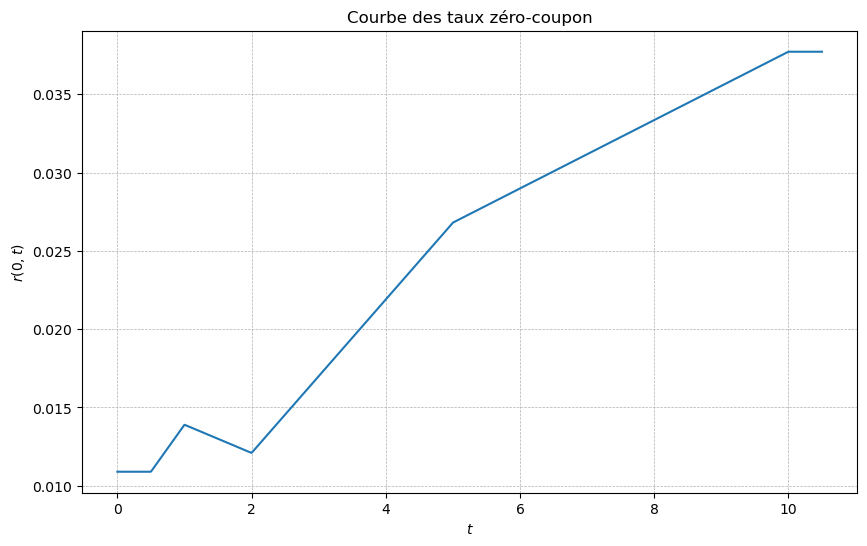

In [40]:
def zero_rate_curve(t) : 
    if(t < 0.5) : return zero_rate_curve(0.5)
    if(0.5 <= t and t<1) : return 2*(t-0.5)*0.0139+2*(1-t)*0.0109
    if(1 <= t and t < 2) : return (t-1)*0.012099+(2-t)*0.0139
    if(2 <= t and t < 5) : return ((t-2)*0.0268+(5-t)*0.012099)/3
    if(5 <= t and t <= 10) : return ((t-5)*0.03771+(10-t)*0.0268)/5
    return zero_rate_curve(10) 

t = np.linspace(0, 10.5, 1000)
y = np.array([zero_rate_curve(ti) for ti in t])

plt.figure(figsize=(10, 6))
plt.plot(t, y)
plt.xlabel(fr"$t$")
plt.ylabel(fr"$r(0,t)$")
plt.title("Courbe des taux zéro-coupon")
plt.grid(linestyle = '--', linewidth = 0.5)
plt.show()

Le prix donné par la table en début de l'exemple est : $ B_3 = 107 + \dfrac{8}{32}$. Le prix d'une obligation étant donnée la courbe zéro coupon est : 

$$B = \displaystyle \sum_{i=1}^n c_i\,\text{exp}\left(-r(0,t_i)t_i\right),$$

où : 

* `n`, le nombre total de flux. 
* `t_cash_flow`, le vecteur des dates auxquelles ont lieux ces flux. 
* `c_cash_flow`, le vecteur des montants versés aux dates initiées par le précédent vecteur.
* `r_zero`, routine permettant de d'évaluer $r(0,t)$ à toute date $t$. 

In [41]:
def bond_price_with_zero_rate_curve(n,t_cash_flow,c_cash_flow,r_zero) : 
    B = 0 
    for i in range (0,n) : 
        discount_factor = np.exp(-t_cash_flow[i]*r_zero(t_cash_flow[i]))
        B += c_cash_flow[i]*discount_factor
    return B 

In [42]:
n = 6
t_cash_flow = [6/12, 12/12, 18/12, 24/12, 30/12, 36/12]
F = 100
C = 0.045
c_cash_flow = [C/2*F] * (n-1) + [(1 + C/2)*F]

B_approx = bond_price_with_zero_rate_curve(n, t_cash_flow, c_cash_flow, zero_rate_curve)
print("B_approx = ", B_approx)

B_approx =  108.19529164800177


L'erreur relative commise est donc : $\dfrac{|B - B_{approx}|}{B}.$

In [43]:
B = 107+8/32
print("Erreur relative = ", np.abs(B-B_approx)/B, "soit ",np.abs(B-B_approx)/B*100, " %.") 

Erreur relative =  0.008813908139876649 soit  0.881390813987665  %.
